In [57]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, normalized_mutual_info_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import shap


from sklearn.decomposition import PCA

In [5]:
# Load in utils file
sys.path.append("/uufs/chpc.utah.edu/common/home/u0914269/clement/projects/20230828_tcga_methylation/side_projects/20232110_TCGA_METHYLATION_CLINICAL_ML/analysis/utils")
from utils import *

In [6]:
# Load in subtype data
X, y = get_subtype_ml_data()

In [ ]:
# Inspecting the data shape
X.shape, y.shape

((698, 275098), (698,))

In [ ]:
# Checking the target counts
np.unique(y, return_counts=True)

(array(['BRCA_Basal', 'BRCA_Her2', 'BRCA_LumA', 'BRCA_LumB', 'BRCA_Normal'],
       dtype=object),
 array([122,  42, 366, 138,  30]))

In [ ]:
# Removing columns with more than 50% missing values
columns_to_drop = np.where(X.isna().sum() >= (0.5 * len(X)))[0]
X_filtered = X.drop(X.columns[columns_to_drop], axis = 1)

# Inspecting the new data shape
len(columns_to_drop), X_filtered.shape

(39370, (698, 235728))

In [ ]:
# numerically encoding the target variable

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

int_to_subtype = {i: subtype for i, subtype in enumerate(target_encoder.classes_)}

# Viewing the encoded variables
print("Integer to Subtype Mapping:", int_to_subtype)  

Integer to Subtype Mapping: {0: 'BRCA_Basal', 1: 'BRCA_Her2', 2: 'BRCA_LumA', 3: 'BRCA_LumB', 4: 'BRCA_Normal'}


In [ ]:
# Generating the test and training data
y_encoded = pd.Series(y_encoded)

X_train, X_test, y_train, y_test = stratified_train_test_split(X_filtered, y_encoded)

In [ ]:
# Viewing the distribution of the target values in the training and test data
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4]), array([ 97,  34, 293, 110,  24])),
 (array([0, 1, 2, 3, 4]), array([25,  8, 73, 28,  6])))

In [ ]:
# Converting the data to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
# The SimpleNN class is written as the neural network model to be used by PyTorchNN
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim =5):
        super(SimpleNN, self).__init__()
        layers = []
        current_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(current_dim, hdim))
            layers.append(nn.ReLU())
            current_dim = hdim
        layers.append(nn.Linear(current_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# The PyTorchNN class is a implementation that allows the PyTorch model to be used in sci-kit learn pipeline
class PyTorchNN(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, hidden_dims, output_dim = 5, epochs = 20, lr = 0.001):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.epochs = epochs
        self.lr = lr
        self.model = SimpleNN(self.input_dim, hidden_dims, self.output_dim)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.lr)
    
    def fit(self, X, y):
        X = torch.tensor(X, dtype = torch.float32)
        y = torch.tensor(y, dtype = torch.long)
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)
        
        self.model.train()
        for epoch in range(self.epochs):
            for X_batch, y_batch in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1)
        return predicted_classes.numpy()
        
    

In [ ]:
# The optuna trial function defines the hyperparameters to be optimized and the pipeline to be used
def optuna_trial(trial):
    print(f"Trial number: {trial.number}")
    # Suggest hyperparameters
    pca_n_components = trial.suggest_int('pca__n_components', 1, 300)
    num_layers = trial.suggest_int('nn__num_layers', 1, 3)
    hidden_dims = [trial.suggest_int(f'nn__hidden_dim{i}', 10, 100) for i in range(num_layers)]
    epochs = trial.suggest_int('nn__epochs', 10, 50)
    lr = trial.suggest_float('nn__lr', 0.0001, 0.01)
    
    # Define the pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Impute missing values using the median
        ('pca', PCA(n_components=pca_n_components)),  # PCA with suggested number of components
        ('nn', PyTorchNN(input_dim=pca_n_components, hidden_dims=hidden_dims, output_dim=5, epochs=epochs, lr=lr))  # PyTorch NN with suggested hyperparameters
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=10)
    
    # Return the mean accuracy
    return scores.mean()

In [ ]:
# Using optuna to search for good hyperparameters
tuning = optuna.create_study(direction = 'maximize')
tuning.optimize(optuna_trial, n_trials = 25)

print(f"Chosen hyperparameters: {tuning.best_params}")

[I 2024-11-26 12:38:25,875] A new study created in memory with name: no-name-4fc48fdb-0651-4c5c-9ebd-eef5f40cf1b3


Trial number: 0


[I 2024-11-26 12:38:54,433] Trial 0 finished with value: 0.7239382239382239 and parameters: {'pca__n_components': 4, 'nn__num_layers': 2, 'nn__hidden_dim0': 84, 'nn__hidden_dim1': 31, 'nn__epochs': 18, 'nn__lr': 0.0011115793830778545}. Best is trial 0 with value: 0.7239382239382239.


Trial number: 1


[I 2024-11-26 12:39:13,716] Trial 1 finished with value: 0.7455759330759332 and parameters: {'pca__n_components': 18, 'nn__num_layers': 1, 'nn__hidden_dim0': 83, 'nn__epochs': 19, 'nn__lr': 0.005242184552193461}. Best is trial 1 with value: 0.7455759330759332.


Trial number: 2


[I 2024-11-26 12:39:37,424] Trial 2 finished with value: 0.7580276705276706 and parameters: {'pca__n_components': 136, 'nn__num_layers': 2, 'nn__hidden_dim0': 13, 'nn__hidden_dim1': 96, 'nn__epochs': 27, 'nn__lr': 0.005909891403509333}. Best is trial 2 with value: 0.7580276705276706.


Trial number: 3


[I 2024-11-26 12:40:13,475] Trial 3 finished with value: 0.793951093951094 and parameters: {'pca__n_components': 241, 'nn__num_layers': 3, 'nn__hidden_dim0': 95, 'nn__hidden_dim1': 49, 'nn__hidden_dim2': 64, 'nn__epochs': 48, 'nn__lr': 0.0003089798443062548}. Best is trial 3 with value: 0.793951093951094.


Trial number: 4


[I 2024-11-26 12:40:31,658] Trial 4 finished with value: 0.7490990990990991 and parameters: {'pca__n_components': 30, 'nn__num_layers': 2, 'nn__hidden_dim0': 23, 'nn__hidden_dim1': 66, 'nn__epochs': 27, 'nn__lr': 0.007336509415958767}. Best is trial 3 with value: 0.793951093951094.


Trial number: 5


[I 2024-11-26 12:41:05,563] Trial 5 finished with value: 0.7616795366795367 and parameters: {'pca__n_components': 239, 'nn__num_layers': 3, 'nn__hidden_dim0': 100, 'nn__hidden_dim1': 75, 'nn__hidden_dim2': 92, 'nn__epochs': 30, 'nn__lr': 0.00559614072524162}. Best is trial 3 with value: 0.793951093951094.


Trial number: 6


[I 2024-11-26 12:41:37,619] Trial 6 finished with value: 0.7867438867438867 and parameters: {'pca__n_components': 215, 'nn__num_layers': 2, 'nn__hidden_dim0': 67, 'nn__hidden_dim1': 33, 'nn__epochs': 26, 'nn__lr': 0.0011122430263101105}. Best is trial 3 with value: 0.793951093951094.


Trial number: 7


[I 2024-11-26 12:41:53,824] Trial 7 finished with value: 0.7436936936936936 and parameters: {'pca__n_components': 12, 'nn__num_layers': 3, 'nn__hidden_dim0': 10, 'nn__hidden_dim1': 72, 'nn__hidden_dim2': 12, 'nn__epochs': 44, 'nn__lr': 0.0009464031851928605}. Best is trial 3 with value: 0.793951093951094.


Trial number: 8


[I 2024-11-26 12:42:26,293] Trial 8 finished with value: 0.7796010296010296 and parameters: {'pca__n_components': 220, 'nn__num_layers': 2, 'nn__hidden_dim0': 37, 'nn__hidden_dim1': 45, 'nn__epochs': 46, 'nn__lr': 0.0055570992877553085}. Best is trial 3 with value: 0.793951093951094.


Trial number: 9


[I 2024-11-26 12:42:57,286] Trial 9 finished with value: 0.7795366795366795 and parameters: {'pca__n_components': 194, 'nn__num_layers': 3, 'nn__hidden_dim0': 29, 'nn__hidden_dim1': 27, 'nn__hidden_dim2': 12, 'nn__epochs': 17, 'nn__lr': 0.004746791035722566}. Best is trial 3 with value: 0.793951093951094.


Trial number: 10


[I 2024-11-26 12:43:33,386] Trial 10 finished with value: 0.7777670527670528 and parameters: {'pca__n_components': 271, 'nn__num_layers': 1, 'nn__hidden_dim0': 51, 'nn__epochs': 40, 'nn__lr': 0.0029782413121918947}. Best is trial 3 with value: 0.793951093951094.


Trial number: 11


[I 2024-11-26 12:43:57,675] Trial 11 finished with value: 0.7526222651222652 and parameters: {'pca__n_components': 151, 'nn__num_layers': 3, 'nn__hidden_dim0': 69, 'nn__hidden_dim1': 14, 'nn__hidden_dim2': 66, 'nn__epochs': 38, 'nn__lr': 0.00014267936015405165}. Best is trial 3 with value: 0.793951093951094.


Trial number: 12


[I 2024-11-26 12:44:37,002] Trial 12 finished with value: 0.8011261261261261 and parameters: {'pca__n_components': 296, 'nn__num_layers': 1, 'nn__hidden_dim0': 62, 'nn__epochs': 35, 'nn__lr': 0.0027259378000525944}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 13


[I 2024-11-26 12:45:16,421] Trial 13 finished with value: 0.7813867438867439 and parameters: {'pca__n_components': 300, 'nn__num_layers': 1, 'nn__hidden_dim0': 100, 'nn__epochs': 50, 'nn__lr': 0.002864938898969247}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 14


[I 2024-11-26 12:45:54,868] Trial 14 finished with value: 0.788561776061776 and parameters: {'pca__n_components': 277, 'nn__num_layers': 1, 'nn__hidden_dim0': 50, 'nn__epochs': 34, 'nn__lr': 0.0028752122206872088}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 15


[I 2024-11-26 12:46:18,633] Trial 15 finished with value: 0.7885135135135135 and parameters: {'pca__n_components': 153, 'nn__num_layers': 3, 'nn__hidden_dim0': 83, 'nn__hidden_dim1': 55, 'nn__hidden_dim2': 54, 'nn__epochs': 11, 'nn__lr': 0.002122311519799895}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 16


[I 2024-11-26 12:46:54,447] Trial 16 finished with value: 0.7849903474903475 and parameters: {'pca__n_components': 254, 'nn__num_layers': 1, 'nn__hidden_dim0': 64, 'nn__epochs': 38, 'nn__lr': 0.0020556808232104935}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 17


[I 2024-11-26 12:47:15,905] Trial 17 finished with value: 0.7813706563706564 and parameters: {'pca__n_components': 94, 'nn__num_layers': 2, 'nn__hidden_dim0': 40, 'nn__hidden_dim1': 93, 'nn__epochs': 50, 'nn__lr': 0.009719562600158318}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 18


[I 2024-11-26 12:47:53,364] Trial 18 finished with value: 0.7832046332046332 and parameters: {'pca__n_components': 292, 'nn__num_layers': 1, 'nn__hidden_dim0': 89, 'nn__epochs': 43, 'nn__lr': 0.003650649857672655}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 19


[I 2024-11-26 12:48:22,931] Trial 19 finished with value: 0.7616312741312742 and parameters: {'pca__n_components': 183, 'nn__num_layers': 3, 'nn__hidden_dim0': 59, 'nn__hidden_dim1': 47, 'nn__hidden_dim2': 53, 'nn__epochs': 34, 'nn__lr': 0.00026676182961188073}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 20


[I 2024-11-26 12:48:58,624] Trial 20 finished with value: 0.7939671814671815 and parameters: {'pca__n_components': 258, 'nn__num_layers': 2, 'nn__hidden_dim0': 75, 'nn__hidden_dim1': 10, 'nn__epochs': 34, 'nn__lr': 0.003953921057951369}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 21


[I 2024-11-26 12:49:33,480] Trial 21 finished with value: 0.7975225225225225 and parameters: {'pca__n_components': 244, 'nn__num_layers': 2, 'nn__hidden_dim0': 75, 'nn__hidden_dim1': 14, 'nn__epochs': 34, 'nn__lr': 0.004081619994433561}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 22


[I 2024-11-26 12:50:10,939] Trial 22 finished with value: 0.772442084942085 and parameters: {'pca__n_components': 267, 'nn__num_layers': 2, 'nn__hidden_dim0': 76, 'nn__hidden_dim1': 10, 'nn__epochs': 34, 'nn__lr': 0.0041841604475097854}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 23


[I 2024-11-26 12:50:44,368] Trial 23 finished with value: 0.7867438867438867 and parameters: {'pca__n_components': 230, 'nn__num_layers': 2, 'nn__hidden_dim0': 76, 'nn__hidden_dim1': 21, 'nn__epochs': 32, 'nn__lr': 0.007312568147049382}. Best is trial 12 with value: 0.8011261261261261.


Trial number: 24


[I 2024-11-26 12:51:15,411] Trial 24 finished with value: 0.7903474903474903 and parameters: {'pca__n_components': 194, 'nn__num_layers': 2, 'nn__hidden_dim0': 74, 'nn__hidden_dim1': 19, 'nn__epochs': 23, 'nn__lr': 0.0039034363837941078}. Best is trial 12 with value: 0.8011261261261261.


Chosen hyperparameters: {'pca__n_components': 296, 'nn__num_layers': 1, 'nn__hidden_dim0': 62, 'nn__epochs': 35, 'nn__lr': 0.0027259378000525944}


In [ ]:
# Storing the chosen optuna hyperparameters for easy access
chosen_params = {'pca__n_components': 296, 'nn__num_layers': 1, 'nn__hidden_dim0': 62, 'nn__epochs': 35, 'nn__lr': 0.0027259378000525944}

In [18]:
optimized_parameters = chosen_params
#optimized_parameters = tuning.best_params

# Training the pipeline with the optimized hyperparameters
# Extract parameters from chosen_params
pca_n_components = chosen_params['pca__n_components']
num_layers = chosen_params['nn__num_layers']
hidden_dims = [chosen_params[f'nn__hidden_dim{i}'] for i in range(num_layers)]
epochs = chosen_params['nn__epochs']
lr = chosen_params['nn__lr']

subtype_nn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values using the median
    ('pca', PCA(n_components=pca_n_components)),  # PCA with chosen number of components
    ('nn', PyTorchNN(input_dim=pca_n_components, hidden_dims=hidden_dims, output_dim=5, epochs=epochs, lr=lr))  # PyTorch NN with chosen hyperparameters
])


subtype_nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('pca', PCA(n_components=296)),
                ('nn',
                 PyTorchNN(epochs=35, hidden_dims=[62], input_dim=296,
                           lr=0.0027259378000525944))])

In [19]:
# Predicting on the test dataset
test_predictions = subtype_nn_pipeline.predict(X_test)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [ ]:
# Evaluating the model on the test dataset
nn_accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {nn_accuracy}")

Accuracy: 0.8142857142857143


In [ ]:
# Inspecting the target variable encoding
int_to_subtype.values()

dict_values(['BRCA_Basal', 'BRCA_Her2', 'BRCA_LumA', 'BRCA_LumB', 'BRCA_Normal'])

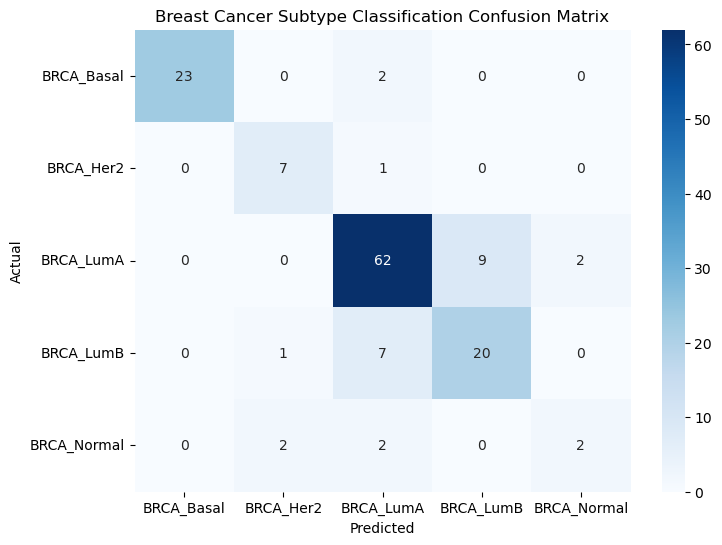

In [ ]:
# Generating and plotting a confusion matrix of the model performance
cm = confusion_matrix(y_test, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=int_to_subtype.values(), yticklabels=int_to_subtype.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation = 0)
plt.title('Breast Cancer Subtype Classification Confusion Matrix')

plt.savefig("02_neural_network_confusion_matrix.png", dpi = 300)

plt.show()

In [59]:
# Generating a classification report for the model
print(classification_report(y_test, test_predictions, target_names = int_to_subtype.values()))

              precision    recall  f1-score   support

  BRCA_Basal       1.00      0.92      0.96        25
   BRCA_Her2       0.70      0.88      0.78         8
   BRCA_LumA       0.84      0.85      0.84        73
   BRCA_LumB       0.69      0.71      0.70        28
 BRCA_Normal       0.50      0.33      0.40         6

    accuracy                           0.81       140
   macro avg       0.75      0.74      0.74       140
weighted avg       0.81      0.81      0.81       140



### Interepreting the relevant PCA components

In [29]:
# Define a function to extract predictions from the PyTorch model
def model_predict(data):
    # Convert the input data to a PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    # Get the model's predictions
    with torch.no_grad():
        outputs = subtype_nn_pipeline.named_steps["nn"].model(data_tensor)
        probabilities = torch.softmax(outputs, dim=1)
    return probabilities.numpy()

In [ ]:
# Grabbing the pca feature names from the pipeline for use in SHAP
transformed_feature_names = subtype_nn_pipeline[:-1].get_feature_names_out()

# Creating a SHAP explainer that focuses on the subtype neural network model
explainer = shap.Explainer(
    model_predict,
    subtype_nn_pipeline[:-1].transform(X_test),
    feature_names=transformed_feature_names,
)


# Compute SHAP values with the correct max_evals parameter
num_features = subtype_nn_pipeline[:-1].transform(X_test).shape[1]
max_evals = 2 * num_features + 1
explanations = explainer(subtype_nn_pipeline[:-1].transform(X_test), max_evals=max_evals)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
PermutationExplainer explainer: 141it [00:37,  3.26it/s]                         


In [32]:
# Extracting the loading values from the PCA step of the pipeline
pca_step = subtype_nn_pipeline.named_steps['pca']
pca_loadings = pca_step.components_
pca_loadings_df = pd.DataFrame(pca_loadings, columns=X_filtered.columns, index=[f"PC{i}" for i in range(1, pca_step.n_components_ + 1)])

pca_loadings_df.head()

id,cg21870274,cg08258224,cg16619049,cg18147296,cg13938959,cg12445832,cg23999112,cg11527153,cg27573606,cg04195702,...,cg26348521,cg03370490,cg16974513,cg23628760,cg04920704,cg07236001,cg27267896,cg23079702,cg21073216,cg22820726
PC1,-0.001365,-0.001908,0.000813,0.000960,-0.000268,0.000816,0.001502,0.000255,-0.000013,0.000516,...,0.001659,0.000300,0.000078,0.000242,-0.001026,-0.000360,-0.000271,-0.000073,0.001022,-0.000865
PC2,-0.003818,-0.003261,-0.002309,-0.000882,-0.004332,-0.003956,-0.003958,-0.001110,-0.000050,-0.000424,...,-0.002315,-0.000551,-0.000119,-0.001267,-0.002820,-0.003589,-0.002278,-0.001879,-0.002755,-0.002678
PC3,0.003671,0.001613,-0.004624,0.000513,-0.000252,-0.002962,0.000459,0.000745,0.000094,0.000948,...,0.000209,0.000446,0.000073,0.000774,0.001428,0.002160,0.000607,0.000770,0.001804,0.001506
PC4,-0.000303,-0.000402,-0.003798,0.000701,-0.001227,-0.000998,-0.003982,0.000263,-0.000106,0.000607,...,-0.003910,-0.000305,-0.000216,-0.000512,-0.000223,-0.000006,-0.000431,-0.002401,-0.001872,-0.001883
PC5,0.002051,0.000357,0.002479,0.002669,0.002568,0.002771,0.001607,0.001582,0.000098,0.001292,...,-0.000812,-0.000006,0.000025,0.001136,-0.000063,0.002707,-0.000831,0.002426,0.000510,0.000376


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


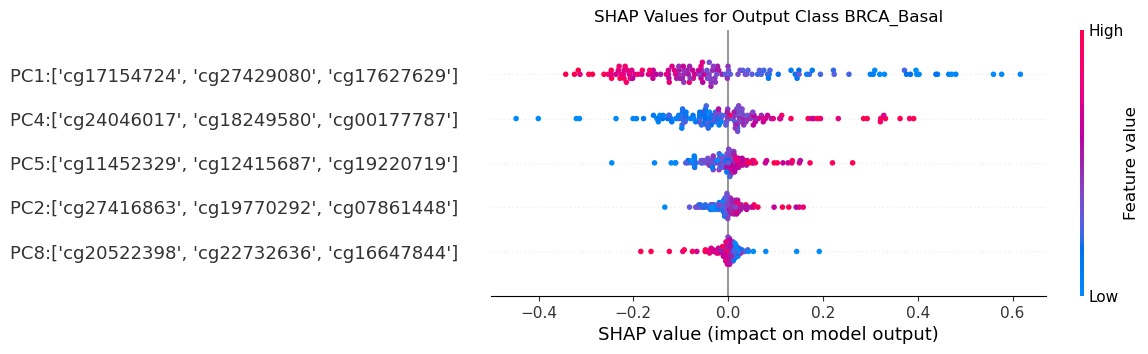

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


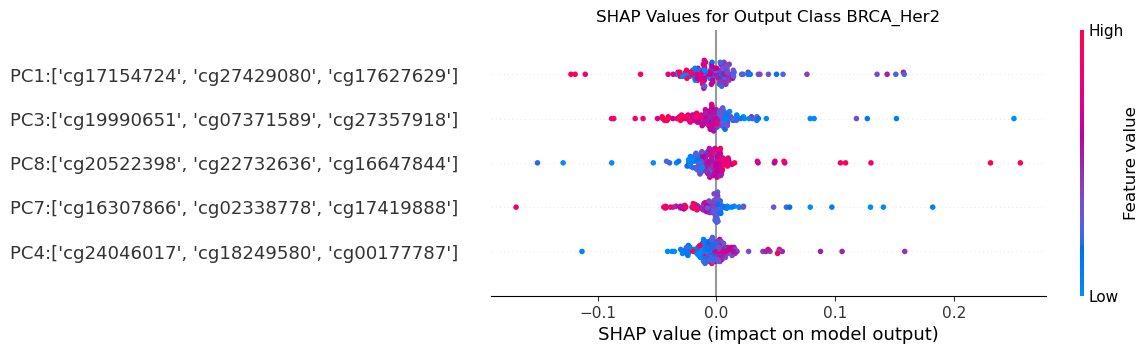

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


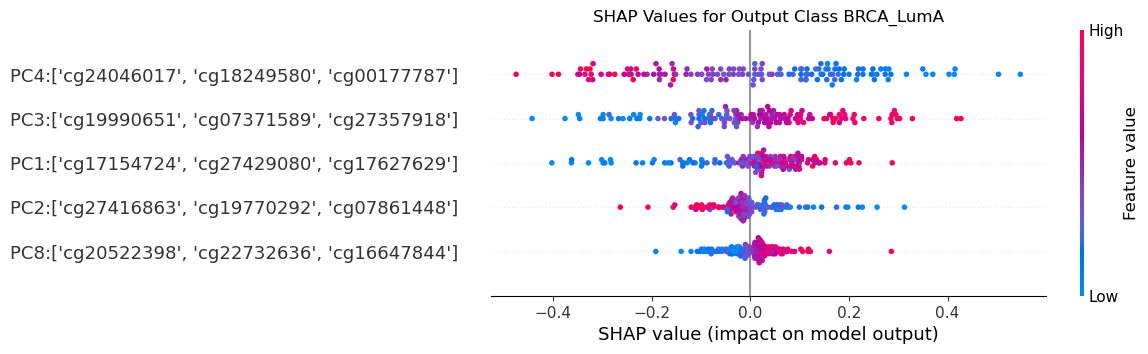

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


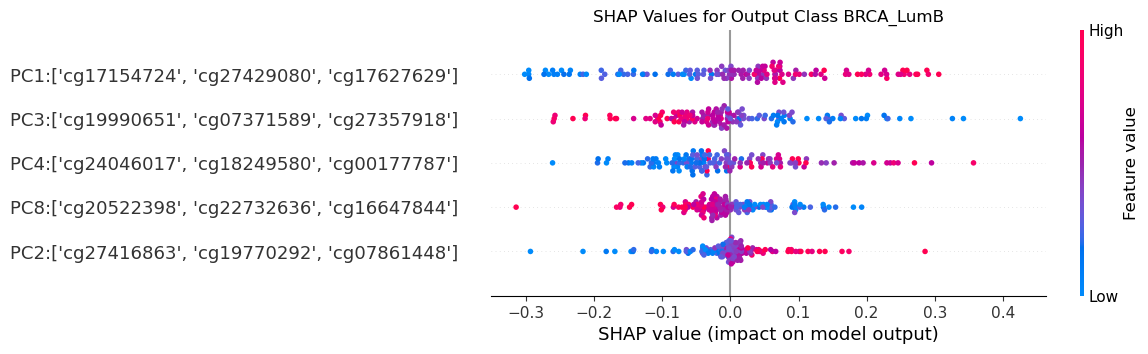

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/envs/sc_bioinfo/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


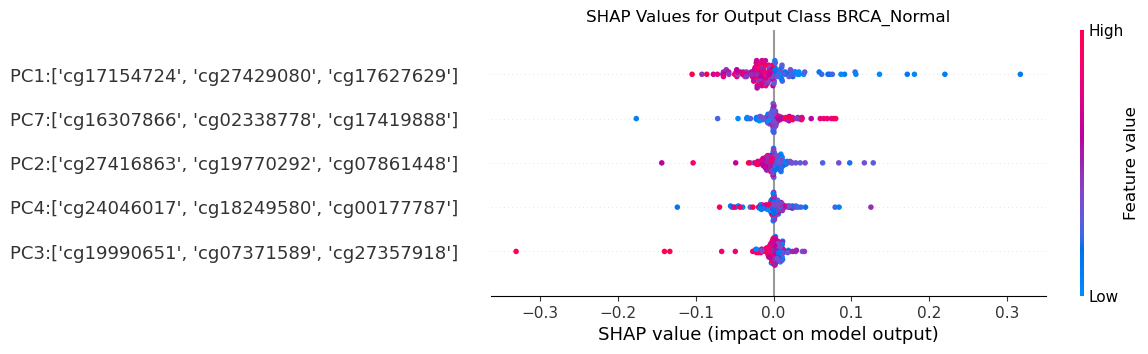

In [ ]:
# Generating a SHAP summary plot for each output class
for i in range(5):  # Assuming there are 5 output classes
    shap_plot_obj = shap.summary_plot(explanations[:, :, i], 
                      features=subtype_nn_pipeline[:-1].transform(X_test), 
                      feature_names=transformed_feature_names, 
                      show=False, 
                      max_display=5)  # Limit to top 5 features for easier viewing
    
    ax = plt.gca()
    
    plotted_components = ax.get_yticklabels()
    plotted_components = [label.get_text() for label in plotted_components]

    new_labels = []
    for component in plotted_components:
        # Selecting the top 3 important CpGs for each component
        pca_loadings_df.iloc[0,:].abs().sort_values(ascending = False)[:3].index
        formatted_component = component.replace('a', '').upper()
        pc_number = int(formatted_component[2:]) + 1
        formatted_component = f"PC{pc_number}"
        new_labels.append(f"{formatted_component}:{pca_loadings_df.loc[formatted_component,:].abs().sort_values(ascending = False)[:3].index.to_list()}")

    # Updating the labels on y axis for increased interpretability
    ax.set_yticklabels(new_labels)

    ax.set_title("SHAP Values for Breast Cancer Subtype Classification")

    
    
    plt.title(f"SHAP Values for Output Class {int_to_subtype[i]}")
    plt.savefig(f"shap_{int_to_subtype[i]}_summary_plot.png", dpi=300)
    plt.show()

### Calculating the normalized mutual information score for comparison

In [56]:
NMI_score = normalized_mutual_info_score(y_test, test_predictions)
NMI_score

0.5815717915318006